# Credit Default Risk

In [2]:
import pandas as pd
import numpy as np

# for data visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import missingno as msno

# for modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, f1_score
from sklearn.dummy import DummyClassifier



from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler

import pickle

In [3]:
def pickle_model (model,model_file_name):
    
    """
    This helper function takes in your model and save it under modelname, in a folder parallel to the parent director called
    pickled_models.
    
    model: the model to save.
    model_file_name: (str) file name to save the model as. 
    """
    print (f'Saving model as {model_file_name}...')
    pickle.dump(model,open(f'./pickled_models/{model_file_name}.sav','wb'))
    print(f'{model_file_name} succesfully saved.')

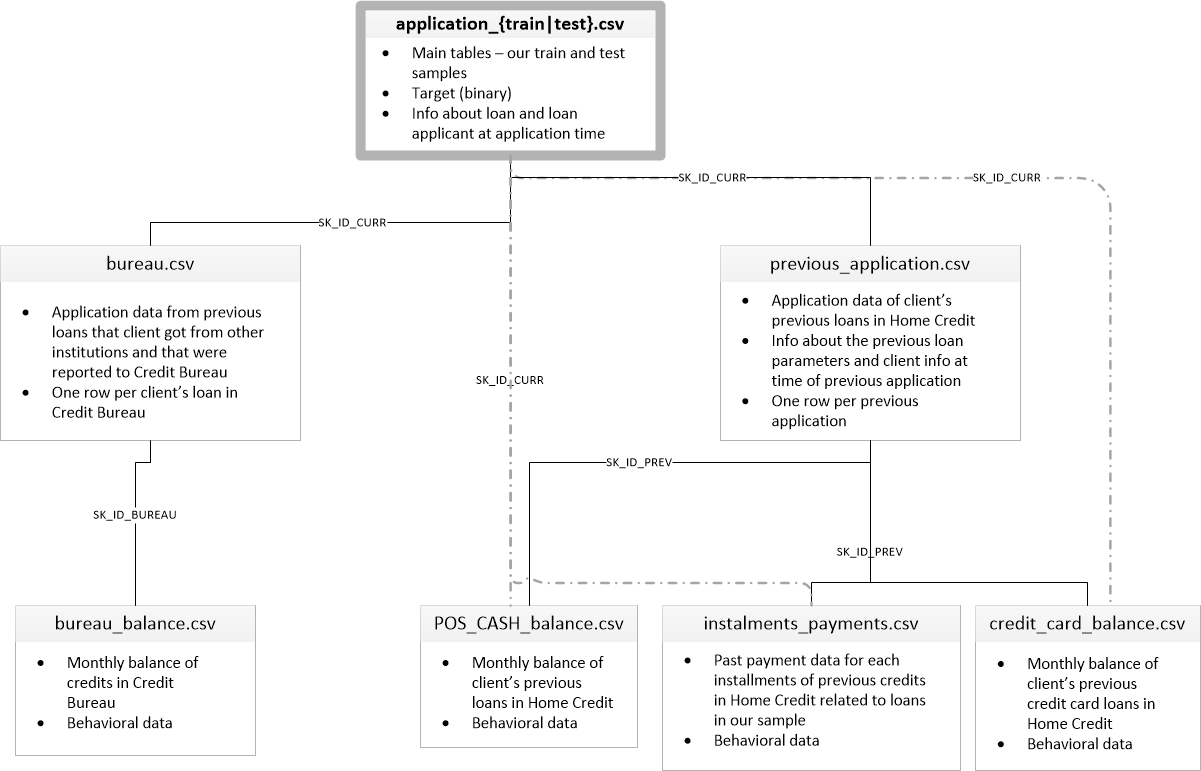

### Load the datasets 

In [4]:
application_train = pd.read_csv('Data/home-credit-default-risk/application_train.csv.zip')
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
application_train.shape

(307511, 122)

In [6]:
# df_application_test_X = pd.read_csv('Data/home-credit-default-risk/application_test.csv')
# df_application_test_X # this data doesn't have target column. 
# we ignore this dataset. Reasoning provided below! 

In [7]:
# sample_df = pd.read_csv('Data/home-credit-default-risk/sample_submission.csv')
# sample_df['TARGET'].value_counts()

# We can not use this as the valdation y set as it has 0.5 values for all entries

In [8]:
# application_test = pd.merge(df_application_test_X, sample_df, on='SK_ID_CURR')[application_train.columns]
# application_test

In [9]:
# (application_test.columns == application_train.columns).sum()

In [10]:
# bureau_df = pd.read_csv('Data/home-credit-default-risk/bureau.csv')
# bureau_df

In [11]:
# bureau_bal_df = pd.read_csv('Data/home-credit-default-risk/bureau_balance.csv')
# bureau_bal_df

In [12]:
# pos_cash_bal_df = pd.read_csv('Data/home-credit-default-risk/POS_CASH_balance.csv')
# pos_cash_bal_df

In [13]:
# prev_app_df = pd.read_csv('Data/home-credit-default-risk/previous_application.csv')
# prev_app_df

In [14]:
# inst_payments_df = pd.read_csv('Data/home-credit-default-risk/installments_payments.csv')
# inst_payments_df

In [15]:
# credit_bal_df = pd.read_csv('Data/home-credit-default-risk/credit_card_balance.csv')
# credit_bal_df

#### Note- After a careful study and consideration of all given files and the goal of the problem, we can notice that most files contain info about the previous loans, which means if we depend on these info, our model will struggle in generalization with new clients with no previous loans experience or info, so we will try to make the best use of only application info to make a model can generalize well. 

The datasets apart from the application train are not in the Data folder as they are big files. However, it can be accessed by downloading it from https://www.kaggle.com/datasets/julianocosta/home-credit.

## EDA

#### Checking for Null Values

In [16]:
# all NaNs
print(f'Total training NaNs = {application_train.isnull().sum().sum()}')

Total training NaNs = 9152465


In [17]:
len(application_train.isnull().sum()[application_train.isnull().sum() != 0].keys())

67

In [18]:
# Only columns with NaNs count and percentage
columns = application_train.isnull().sum()[application_train.isnull().sum() != 0].keys()
nans_count = application_train.isnull().sum()[application_train.isnull().sum() != 0].values
nans_percentage = application_train.isnull().sum()[application_train.isnull().sum() != 0].values/application_train.shape[0]

# create a dataframe from the extracted info. 
nans_df = pd.DataFrame({'Column':columns, 'No. of NaNs':nans_count, '% of NaNs in Column':nans_percentage*100})
nans_df = nans_df.sort_values(by='% of NaNs in Column', ascending=False)
nans_df

,Column,No. of NaNs,% of NaNs in Column
41,COMMONAREA_MEDI,214865,69.872297
13,COMMONAREA_AVG,214865,69.872297
27,COMMONAREA_MODE,214865,69.872297
49,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
35,NONLIVINGAPARTMENTS_MODE,213514,69.432963
...,...,...,...
7,EXT_SOURCE_2,660,0.214626
1,AMT_GOODS_PRICE,278,0.090403
0,AMT_ANNUITY,12,0.003902
5,CNT_FAM_MEMBERS,2,0.000650


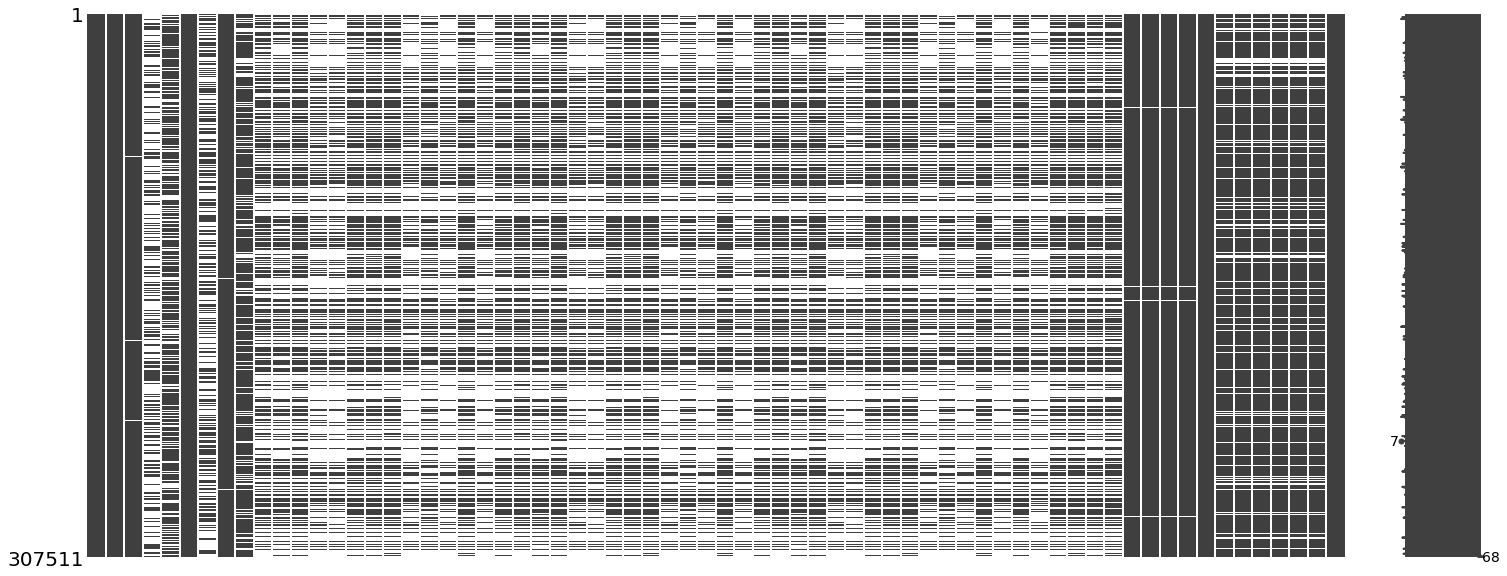

In [19]:
# visualize columns with NaNs distribution over target
msno.matrix(application_train[list(columns)+['TARGET']].sort_values(by='TARGET'));

##### We decide to deal with Null values in the following way - 

- NaNs distribution is random, so imputations won't be biased towards certain target class.
- Columns with large percentage of NaNs (> 40%) will be dropped.
- Other columns will be imputed according the column dtype.

### Data Cleaning

In [20]:
# We make copies of our datasets before we start cleaning and use the copy going ahead. 

train_df = application_train.copy()

In [21]:
# We start with dropping the columns which have more than 40% NaNs

## nans_df only includes and columns which have a NaN value. So we first filter out the columns which we want to drop
drop_col_list = nans_df[nans_df['% of NaNs in Column']>40]['Column'].tolist()

## make a list of columns we want to keep
keep_col_list = [cols for cols in train_df.columns if cols not in drop_col_list]

## overwrite the df with the columns we want to keep
train_df = train_df[keep_col_list]

In [22]:
# Sanity check 

print(train_df.shape)

(307511, 73)


In [23]:
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_C

#### Lets look deeper into the columns by Data Type

In [24]:
train_df.dtypes.value_counts()

int64      41
float64    20
object     12
dtype: int64

##### Numerical Data Type

In [25]:
#create a list of columns which are numerical datatypes (float and int)
num_cols = train_df.select_dtypes(exclude='object').columns.tolist()
len(num_cols)

61

To check for continuous and categorical columns, we make boxplots - will give us a sense of the statistics of the column data. We also check the outliers

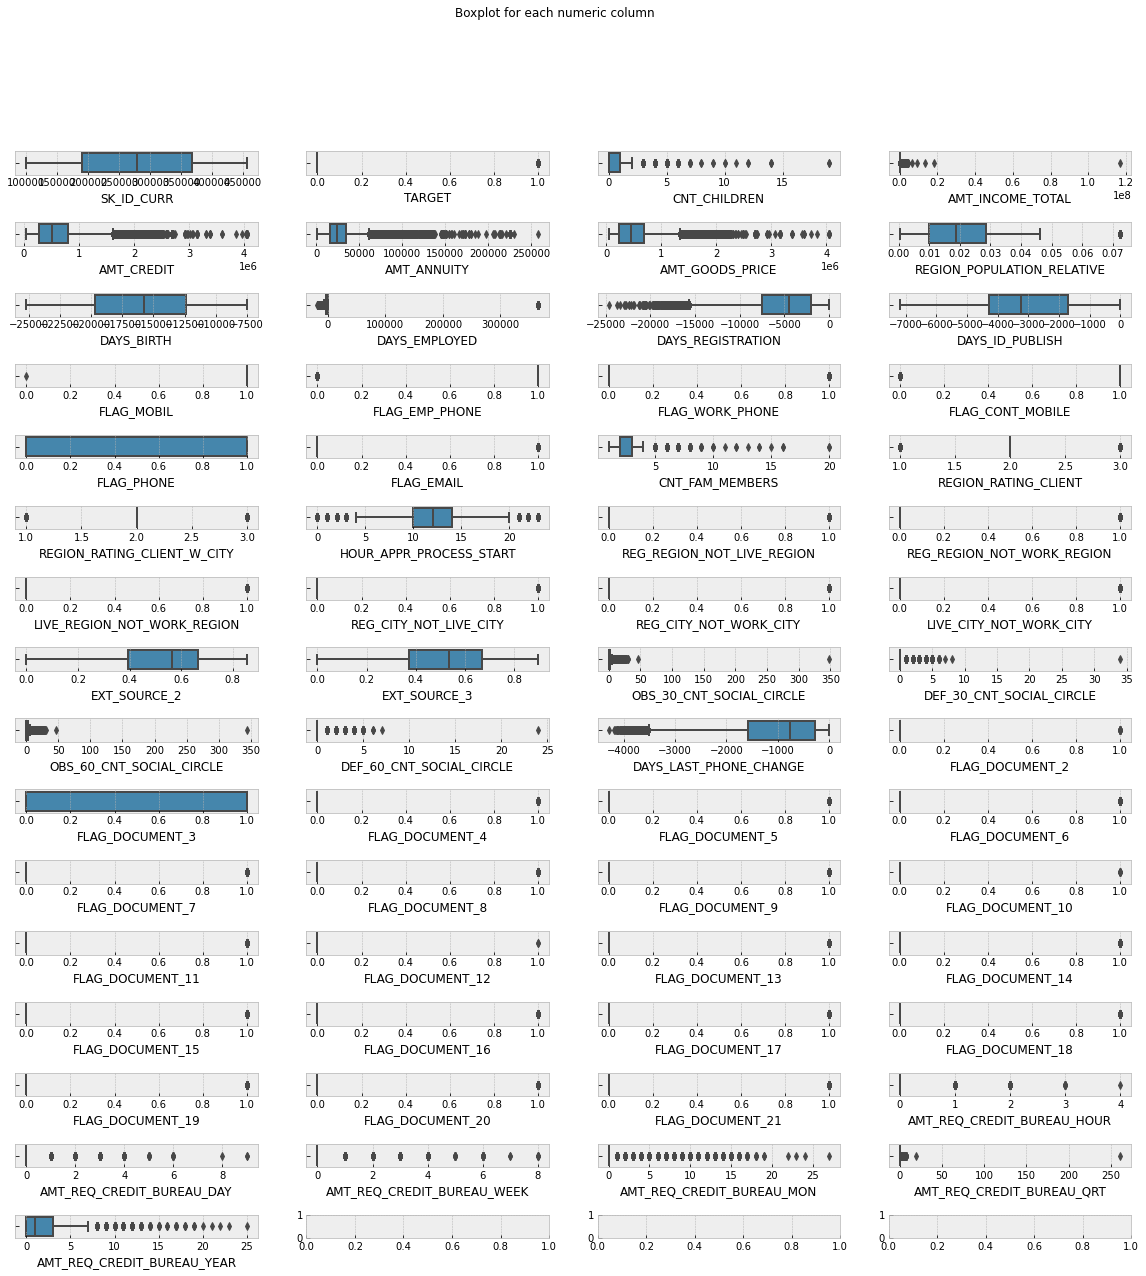

In [26]:
# draw boxplots for each numeric column 
fig, axs = plt.subplots(nrows=16, ncols=4, figsize=(20, 20))
fig.suptitle('Boxplot for each numeric column')
plt.subplots_adjust(hspace=2)


for column, ax in zip(num_cols, axs.ravel()):
    sns.boxplot(ax=ax, data=train_df, x=column)

Looking at the statics of the columns and from the column description in the Data Folder, we understand all columns except Flags column are continuous. 

In [27]:
cont_cols = [cols for cols in num_cols if cols[:5]!='FLAG_']
cont_cols.remove('TARGET')
len(cont_cols)

34

Let's take a deeper look into the continuous columns - descriptive statistics:

In [28]:
train_df[cont_cols[:17]].describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,2.000000,2.000000,2.000000,10.000000,0.000000,0.000000
50%,278202.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,-3254.000000,2.000000,2.000000,2.000000,12.000000,0.000000,0.000000
75%,367142.500000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,-1720.000000,3.000000,2.000000,2.000000,14.000000,0.000000,0.000000
max,456255.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,0.000000,20.000000,3.000000,3.000000,23.000000,1.000000,1.000000


Observations-
- The maximum number of children is 19 with Q3 of 1 - this looks like an outlier.
- The maximum income of a the clients is about 30 times the maximum amount of the loans.
- All days columns are negative values
- Maximum days employed is 365243 days ~ 1000 years and minimum is -17912 days ~ 49 years, this is not correct data

In [29]:
train_df[cont_cols[17:]].describe()

,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,307511.000000,3.068510e+05,246546.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.040659,0.078173,0.230454,0.179555,5.143927e-01,0.510853,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.197499,0.268444,0.421124,0.383817,1.910602e-01,0.194844,2.400989,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,0.000000,0.000000,0.000000,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,3.924574e-01,0.370650,0.000000,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,5.659614e-01,0.535276,0.000000,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,6.636171e-01,0.669057,2.000000,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,8.549997e-01,0.896010,348.000000,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Most features look like they have outliers so will normalize the features to work with models which are sensitive to outliers. 

Check how many entries have values 15+ for children 

In [30]:
train_df['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
19         2
12         2
10         2
9          2
8          2
11         1
Name: CNT_CHILDREN, dtype: int64

We drop these two entries

In [31]:
train_df = train_df.loc[train_df['CNT_CHILDREN']!=19]

In [32]:
train_df.shape

(307509, 73)

Check the total income column for values more than 100M

In [33]:
train_df[train_df['AMT_INCOME_TOTAL']>1e+8]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
12840,114967,1,Cash loans,F,N,Y,1,117000000.0,562491.0,26194.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


There is only one value for more than 100M and the credit to income ratio is very low. This could be an error and we drop this entry

In [34]:
train_df = train_df.loc[train_df['AMT_INCOME_TOTAL']<=1e+8]

In [35]:
train_df.shape

(307508, 73)

Check the maximum value for days employed:

In [36]:
#check how many entries with 365243 days

outlier_days_employed = len(train_df[train_df['DAYS_EMPLOYED']==365243])
outlier_days_employed/len(train_df)

0.18007336394500306

18% of entries have this days employed as 1000 years which is probably an error. We cannot drop these entries so we replace it with the mean value.

In [37]:
len(train_df[train_df['DAYS_BIRTH']==0])

0

In [38]:
len(train_df[train_df['DAYS_EMPLOYED']==0])

2

In [39]:
len(train_df[train_df['DAYS_ID_PUBLISH']==0])

16

In [40]:
len(train_df[train_df['DAYS_LAST_PHONE_CHANGE']==0])

37671

In [41]:
len(train_df[train_df['DAYS_REGISTRATION']==0])

80

In [42]:
days_cols = train_df.columns[train_df.columns.str.contains('DAYS')]
days_cols

Index(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

In [43]:
train_df['DAYS_EMPLOYED'] = train_df['DAYS_EMPLOYED'].apply(lambda x: np.nan if x==0.0 else x)
train_df['DAYS_REGISTRATION'] = train_df['DAYS_REGISTRATION'].apply(lambda x: np.nan if x==0.0 else x)
train_df['DAYS_ID_PUBLISH'] = train_df['DAYS_ID_PUBLISH'].apply(lambda x: np.nan if x==0.0 else x)
train_df['DAYS_LAST_PHONE_CHANGE'] = train_df['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: np.nan if x==0.0 else x)
train_df.shape

(307508, 73)

##### Object Data Type

In [44]:
train_df['NAME_CONTRACT_TYPE'].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [45]:
# Let's look at the columns with Object DataType and check the unique values for each. 

## create a dataframe with object dtype columns
unique_df = pd.DataFrame(train_df.select_dtypes('object').nunique()).reset_index()
unique_df.columns = ['Column', 'No. of unique values']
unique_df['list of unique values'] = unique_df['Column'].apply(lambda x: train_df[x].unique())
unique_df.sort_values(by='No. of unique values')

,Column,No. of unique values,list of unique values
0,NAME_CONTRACT_TYPE,2,"[Cash loans, Revolving loans]"
2,FLAG_OWN_CAR,2,"[N, Y]"
3,FLAG_OWN_REALTY,2,"[Y, N]"
1,CODE_GENDER,3,"[M, F, XNA]"
6,NAME_EDUCATION_TYPE,5,"[Secondary / secondary special, Higher educati..."
7,NAME_FAMILY_STATUS,6,"[Single / not married, Married, Civil marriage..."
8,NAME_HOUSING_TYPE,6,"[House / apartment, Rented apartment, With par..."
4,NAME_TYPE_SUITE,7,"[Unaccompanied, Family, Spouse, partner, Child..."
10,WEEKDAY_APPR_PROCESS_START,7,"[WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY..."
5,NAME_INCOME_TYPE,8,"[Working, State servant, Commercial associate,..."


#### Check Duplicates

In [46]:
train_df.duplicated().sum()

0

#### Check Target Column Balance

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

In [47]:
# target value counts per each class
print('Count of Each Class\n' + '-'*20)
print(train_df['TARGET'].value_counts(normalize=True))

Count of Each Class
--------------------
0    0.919274
1    0.080726
Name: TARGET, dtype: float64


Text(0, 0.5, 'Count')

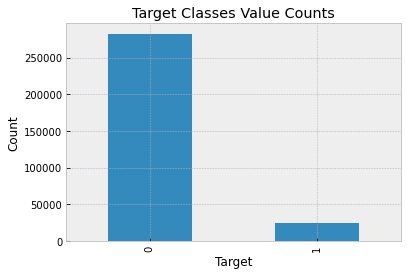

In [48]:
# visualize TARGET value counts
train_df['TARGET'].value_counts().plot(kind='bar');
plt.title('Target Classes Value Counts')
plt.xlabel('Target')
plt.ylabel('Count')

Observations- 
- Most clients are able to repay the loan and only about 8% of the clients have difficulties in repayment. 
- The target is imbalanced and for modeling purpose, data should be balanced. 
- In case of imbalanced data, the accuracy is not the accurate evaluation metric. ROC AUC and F1-scores are good choices for evaluation metrics in this case.

#### Data Analysis - Feature relation with target

In [49]:
# Top 5 Columns with Positive Correlation with our TARGET 
print('Top 5 Columns with Positive Correlation with TARGET\n', '-'*50)
print(train_df.corr()['TARGET'].sort_values().tail(5))

# Negative ones
print('\nTop 5 Columns with Negative Correlation with TARGET\n', '-'*50)
print(train_df.corr()['TARGET'].sort_values().head(5))

Top 5 Columns with Positive Correlation with TARGET
 --------------------------------------------------
DAYS_LAST_PHONE_CHANGE         0.054899
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060894
DAYS_BIRTH                     0.078235
TARGET                         1.000000
Name: TARGET, dtype: float64

Top 5 Columns with Negative Correlation with TARGET
 --------------------------------------------------
EXT_SOURCE_3                 -0.178898
EXT_SOURCE_2                 -0.160455
DAYS_EMPLOYED                -0.044925
AMT_GOODS_PRICE              -0.039646
REGION_POPULATION_RELATIVE   -0.037221
Name: TARGET, dtype: float64


There is no high correlation between the target and any of the features. We note that EXT_SOURCE (Normalized score from external data source) is important to our target. 

In [50]:
train_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting the data set into train and test data

Our dataset is already split into a train and test data. However, the test data given doesn't have the target values. So, we use our training df to split our data into training and test set to start modeling and validate our final model on the test set. We want to split the training and test data into features(X) and target(y).  

In [51]:
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

## Bringing in Our Modeling Class from before

In [52]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''

    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()

    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        Args:
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)
        '''

        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)


    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
            y=self.cv_results,
            color='orange',
            size=10,
            alpha=0.8,
            ax=ax
        )

        return ax

    def print_summary(self):
        roc = plot_roc_curve(self.model, self.X , self.y);
        cm = plot_confusion_matrix(self.model, self.X, self.y);
        preds = self.model.predict(self.X)
        f1_ = f1_score(self.y, preds)
        cv_summary = (
            f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')

        print(f' \n  f1_score is {f1_}', cv_summary ,cm, roc) 

## Dummy Model

In [53]:
dummy_model = DummyClassifier(strategy = 'most_frequent')
dummy_model.fit(X_train, y_train)
dummy_model.predict(X_train)[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.0 CV Results for `dummy_model` model:
            0.91915 ± 0.00001 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fa97d5cf280> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7fa9789ed190>


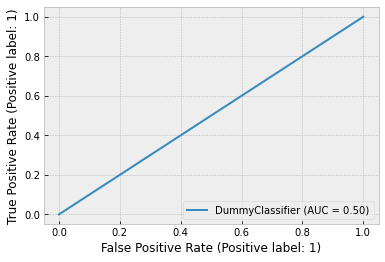

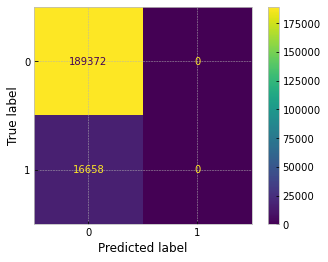

In [54]:
dummy_pipe = ModelWithCV(dummy_model, model_name='dummy_model', X=X_train, y=y_train)
dummy_pipe.print_summary()

# Column Transformers

In [55]:
all_cols = X_train.columns

In [56]:
# list columns based on categorical data and continuous data
cont_cols #already defined above # includes only numeric columns
cat_cols = [i for i in all_cols if i not in cont_cols] #includes object type and numeric type

In [57]:
#sanity check
len(all_cols) == len(cat_cols) + len(cont_cols)

True

In [58]:
def grab_continuous(df):
    return df[cont_cols]

In [59]:
grab_continuous(X_train)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
137880,259903,0,180000.0,659610.0,21406.5,472500.0,0.024610,-23081,365243.0,-921.0,...,0.0,17.0,0.0,-679.0,0.0,0.0,0.0,0.0,0.0,5.0
284412,429375,0,270000.0,675000.0,33750.0,675000.0,0.008230,-16464,-4760.0,-4260.0,...,0.0,0.0,0.0,-1107.0,0.0,0.0,0.0,0.0,2.0,5.0
32185,137318,0,90000.0,135000.0,6750.0,135000.0,0.011703,-17715,-753.0,-10461.0,...,0.0,1.0,0.0,-2401.0,0.0,0.0,0.0,0.0,0.0,0.0
125667,245726,0,112500.0,284400.0,15138.0,225000.0,0.072508,-16965,-236.0,-30.0,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
290509,436566,0,157500.0,343800.0,10921.5,225000.0,0.007274,-22672,-776.0,-8376.0,...,0.0,0.0,0.0,-46.0,0.0,0.0,0.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119880,239010,2,90000.0,523597.5,25317.0,468000.0,0.025164,-13103,-313.0,-2344.0,...,0.0,1.0,0.0,-707.0,0.0,0.0,0.0,0.0,0.0,1.0
259180,399942,0,157500.0,50940.0,5089.5,45000.0,0.018634,-22411,365243.0,-6826.0,...,0.0,0.0,0.0,-2479.0,NaN,NaN,NaN,NaN,NaN,NaN
131933,253017,2,243000.0,545040.0,26640.0,450000.0,0.010006,-12589,-369.0,-1849.0,...,0.0,0.0,0.0,-229.0,0.0,0.0,0.0,0.0,0.0,1.0
146868,270276,0,315000.0,577741.5,20880.0,477000.0,0.019689,-15694,-2741.0,-4245.0,...,0.0,1.0,0.0,-1638.0,0.0,0.0,0.0,1.0,0.0,8.0


In [60]:
GrabContinuous = FunctionTransformer(grab_continuous)

In [61]:
def grab_categorical(df):
    return df[cat_cols]

In [62]:
grab_categorical(X_train)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
137880,Cash loans,F,N,Y,"Spouse, partner",Pensioner,Secondary / secondary special,Married,House / apartment,1,...,0,0,0,0,0,0,0,0,0,0
284412,Revolving loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,1,...,0,0,0,0,0,0,0,0,0,0
32185,Revolving loans,F,N,Y,"Spouse, partner",Working,Higher education,Married,House / apartment,1,...,0,0,0,0,0,0,0,0,0,0
125667,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,Rented apartment,1,...,0,0,0,0,1,0,0,0,0,0
290509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119880,Cash loans,F,Y,Y,"Spouse, partner",Commercial associate,Secondary / secondary special,Married,House / apartment,1,...,0,0,0,0,0,0,0,0,0,0
259180,Cash loans,F,N,Y,Family,Pensioner,Secondary / secondary special,Single / not married,House / apartment,1,...,0,0,0,0,0,0,0,0,0,0
131933,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,1,...,0,0,0,0,0,0,0,0,0,0
146868,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,1,...,0,0,0,0,0,0,0,0,0,0


In [63]:
GrabCategorical = FunctionTransformer(grab_categorical)

In [64]:
# We'll throw these mini-pipelines into our ColumnTransformer: continuous and categorical

subpipe_cont = Pipeline(steps=[('get_cont', GrabContinuous),
                            ('num_impute', SimpleImputer()),
                           ('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('get_cat', GrabCategorical),
                              ('cat_impute', SimpleImputer(strategy='most_frequent')),
                             ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [65]:
cat_index = X_train.columns.get_indexer(cat_cols).tolist()
cont_index = X_train.columns.get_indexer(cont_cols).tolist()

In [66]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.

ct = ColumnTransformer(transformers = [
    ('subpipe_cont', subpipe_cont, cont_index),
    ('subpipe_cat', subpipe_cat, cat_index)
])

In [67]:
ct_df = pd.DataFrame(ct.fit_transform(X_train))

## ct_df.head() # 210 columns

### Model Pipelines

##### Logistic Regression

In [97]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.
# we start with a simple Logistic Regression with no parameter tuning.

logreg_model_pipe= Pipeline(steps=[
    ('ct', ct),
    ('logreg', LogisticRegression(random_state=42))
])

In [98]:
logreg_model_pipe.fit(X_train, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cont',
                                                  Pipeline(steps=[('get_cont',
                                                                   FunctionTransformer(func=<function grab_continuous at 0x7f84e08350d0>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 5, 6, 7, 8, 9, 15, 16, 17,
                                                   18, 19, 27, 28, 29, 31, 32,
                                                   33, 34, 35, 36, 37, 39, 40,
                                                   41, 42, 43, 44, 45, 66, 67, ...]),
                                        

In [99]:
# Use the class with logreg pipe

log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train, y=y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [100]:
pickle_model(log_pipe, 'log_pipe')

Saving model as log_pipe...
log_pipe succesfully saved.


In [101]:
# log_pipe=pickle.load(open('pickled_models/log_pipe.sav'))

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.026774231263884018 CV Results for `log_pipe` model:
            0.91914 ± 0.00030 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f84e06d2820> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f84e5075820>


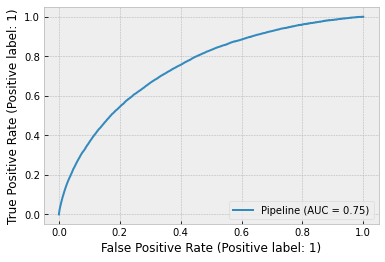

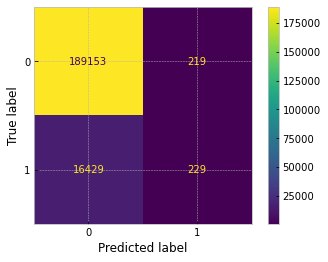

In [102]:
log_pipe.print_summary()

<AxesSubplot:title={'center':'CV Results for `log_pipe` Model'}>

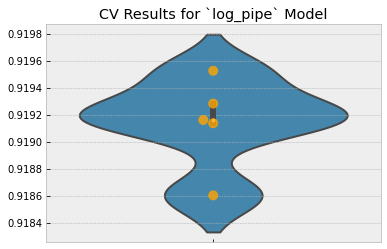

In [103]:
fig, ax = plt.subplots()

log_pipe.plot_cv(ax=ax)

##### Random Forest Classifier

In [104]:
# Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([
    ('ct', ct),
    ('rfc', rfc)
])

In [105]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cont',
                                                  Pipeline(steps=[('get_cont',
                                                                   FunctionTransformer(func=<function grab_continuous at 0x7f84e08350d0>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 5, 6, 7, 8, 9, 15, 16, 17,
                                                   18, 19, 27, 28, 29, 31, 32,
                                                   33, 34, 35, 36, 37, 39, 40,
                                                   41, 42, 43, 44, 45, 66, 67, ...]),
                                        

In [106]:
forest_pipe = ModelWithCV(rfc_model_pipe, 'forest_pipe_cv', X_train, y_train)

In [107]:
pickle_model(forest_pipe, 'forest_pipe')

Saving model as forest_pipe...
forest_pipe succesfully saved.


In [108]:
# forest_pipe=pickle.load(open('pickled_models/forest_pipe.sav'))

<AxesSubplot:title={'center':'CV Results for `forest_pipe_cv` Model'}>

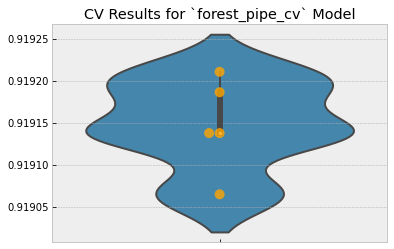

In [109]:
fig, ax = plt.subplots()
forest_pipe.plot_cv(ax)

In [110]:
log_pipe.print_cv_summary()

AttributeError: 'ModelWithCV' object has no attribute 'print_cv_summary'

## Tuning and Cross-Validating

In [ ]:
# GridSearch

params = {}

params['rfc__criterion'] = ['gini', 'entropy']
params['rfc__min_samples_leaf'] = [5,10]


In [93]:
params

{'rfc__criterion': ['gini', 'entropy'], 'rfc__min_samples_leaf': [5, 10]}

In [94]:
gs = GridSearchCV(
    estimator = rfc_model_pipe, 
    param_grid=params, 
    cv = 5, n_jobs=-2
)

In [95]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_cont',
                                                                         Pipeline(steps=[('get_cont',
                                                                                          FunctionTransformer(func=<function grab_continuous at 0x7f7caa53c3a0>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 5,
                                                                          6, 7,
  

In [256]:
pickle_model(gs, 'gs')

Saving model as gs...
gs succesfully saved.


In [ ]:
# gs=pickle.load(open('pickled_models/gs'))

In [96]:
gs.cv_results_

{'mean_fit_time': array([125.62938685, 114.46607537, 118.86178398, 100.12662964]),
 'std_fit_time': array([0.28486741, 4.15992781, 5.74929623, 1.70546407]),
 'mean_score_time': array([2.44558492, 2.91793842, 2.75178404, 1.83343682]),
 'std_score_time': array([0.06621174, 0.16561834, 0.2063968 , 0.43246453]),
 'param_rfc__criterion': masked_array(data=['gini', 'gini', 'entropy', 'entropy'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_rfc__min_samples_leaf': masked_array(data=[5, 10, 5, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 5},
  {'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 10},
  {'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 5},
  {'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 10}],
 'split0_test_score': array([0.91913799, 0.91913799, 0.91913799, 0.91913799]),
 'split1_

In [97]:
gs.cv_results_['mean_test_score']

array([0.9191477, 0.9191477, 0.9191477, 0.9191477])

In [98]:
gs.best_params_

{'rfc__criterion': 'gini', 'rfc__min_samples_leaf': 5}

##### Target Classes Balancing
As in our target major is 91% and minor is 9%, we can't use either oversampling only as the minor is very small or downsampling only as we will lose alot of our data, so we will apply both oversample on minor class firstly, then downsample the major one.

In [66]:
# create oversampler, downsampler instants
oversampler = SMOTE(sampling_strategy=0.25)                     # minor/major = 1/4
undersampler = RandomUnderSampler(sampling_strategy=0.75)       # minor/major = 3/4

Random Forest

In [69]:
# create pipeline
rf = RandomForestClassifier(n_estimators=50, max_depth=25, random_state=42)
steps = [('ct', ct), ('oversampler', oversampler), ('undersampler', undersampler), ('model', rf)]
rf_pipeline2 = ImPipeline(steps=steps)

# train 
rf_pipeline2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cont',
                                                  Pipeline(steps=[('get_cont',
                                                                   FunctionTransformer(func=<function grab_continuous at 0x7f760a664670>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 5, 6, 7, 8, 9, 15, 16, 17,
                                                   18, 19, 27, 28, 29, 31, 32,
                                                   33, 34, 35, 36, 37, 39, 40,
                                                   41, 42, 43, 44, 45, 66, 67, ...]),
                                        

In [145]:
forest_smt_pipe = ModelWithCV(rf_pipeline2, 'rf_pipeline2', X_train, y_train)

In [257]:
pickle_model(forest_smt_pipe, 'forest_smt_pipe')

Saving model as forest_smt_pipe...
forest_smt_pipe succesfully saved.


In [ ]:
# forest_smt_pipe=pickle.load(open('pickled_models/forest_smt_pipe.sav'))

<AxesSubplot:title={'center':'CV Results for `rf_pipeline2` Model'}>

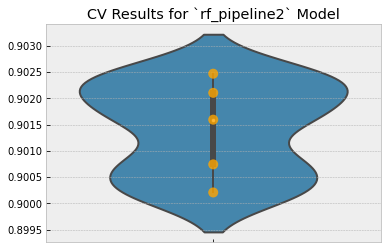

In [146]:
fig, ax = plt.subplots()
forest_smt_pipe.plot_cv(ax)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.8598918918918919 CV Results for `rf_pipeline2` model:
            0.90142 ± 0.00084 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f7aa7f24ee0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f7aa7e0dfa0>


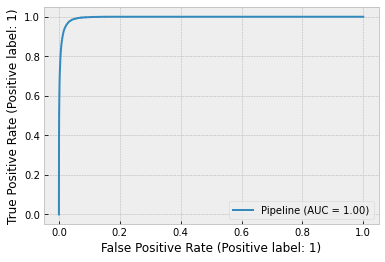

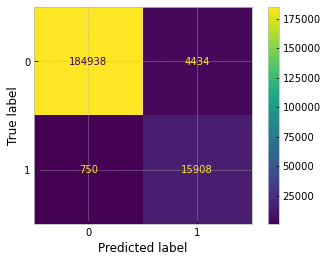

In [147]:
forest_smt_pipe.print_summary()

Ada Boosting

In [157]:
# create pipeline
adaboost = AdaBoostClassifier(n_estimators=70, random_state=42)
steps = [('ct', ct), ('oversampler', oversampler), ('undersampler', undersampler), ('model', adaboost)]
ada_pipeline2 = ImPipeline(steps=steps)

# train 
ada_pipeline2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cont',
                                                  Pipeline(steps=[('get_cont',
                                                                   FunctionTransformer(func=<function grab_continuous at 0x7f7caa53c3a0>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 5, 6, 7, 8, 9, 15, 16, 17,
                                                   18, 19, 27, 28, 29, 31, 32,
                                                   33, 34, 35, 36, 37, 39, 40,
                                                   41, 42, 43, 44, 45, 66, 67, ...]),
                                        

In [158]:
ada_smt_pipe = ModelWithCV(ada_pipeline2, 'ada_pipeline2', X_train, y_train)

In [258]:
pickle_model(ada_smt_pipe, 'ada_smt_pipe')

Saving model as ada_smt_pipe...
ada_smt_pipe succesfully saved.


In [ ]:
# ada_smt_pipe=pickle.load(open('pickled_models/ada_smt_pipe.sav'))

<AxesSubplot:title={'center':'CV Results for `ada_pipeline2` Model'}>

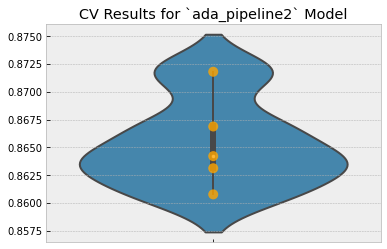

In [159]:
fig, ax = plt.subplots()
ada_smt_pipe.plot_cv(ax)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.25583197498864335 CV Results for `ada_pipeline2` model:
            0.86536 ± 0.00378 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f7aa93e8940> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f7aa8862190>


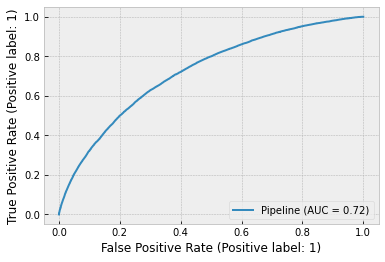

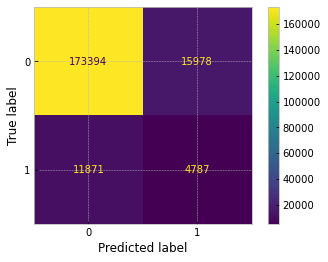

In [160]:
ada_smt_pipe.print_summary()

Gradient Boosting

In [165]:
# create pipeline
gbm = GradientBoostingClassifier(n_estimators=50, random_state=42)
steps = [('ct', ct), ('oversampler', oversampler), ('undersampler', undersampler), ('model', gbm)]
gbm_pipeline2 = ImPipeline(steps=steps)

# train 
gbm_pipeline2.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cont',
                                                  Pipeline(steps=[('get_cont',
                                                                   FunctionTransformer(func=<function grab_continuous at 0x7f7caa53c3a0>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 5, 6, 7, 8, 9, 15, 16, 17,
                                                   18, 19, 27, 28, 29, 31, 32,
                                                   33, 34, 35, 36, 37, 39, 40,
                                                   41, 42, 43, 44, 45, 66, 67, ...]),
                                        

In [166]:
gbm_smt_pipe = ModelWithCV(gbm_pipeline2, 'gbm_pipeline2', X_train, y_train)

In [259]:
pickle_model(gbm_smt_pipe, 'gbm_smt_pipe')

Saving model as gbm_smt_pipe...
gbm_smt_pipe succesfully saved.


In [ ]:
# gbm_smt_pipe=pickle.load(open('pickled_models/gbm_smt_pipe.sav'))

<AxesSubplot:title={'center':'CV Results for `gbm_pipeline2` Model'}>

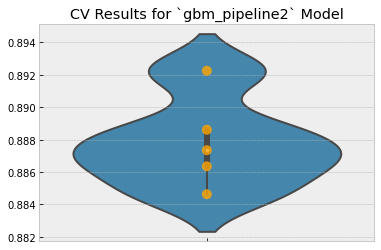

In [167]:
fig, ax = plt.subplots()
gbm_smt_pipe.plot_cv(ax)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.2512036157599974 CV Results for `gbm_pipeline2` model:
            0.88784 ± 0.00256 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f7aa9593880> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f7aa958d7f0>


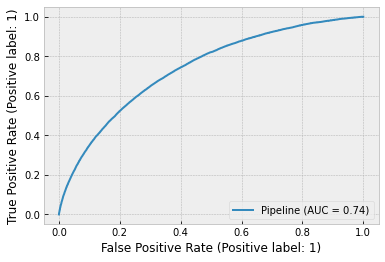

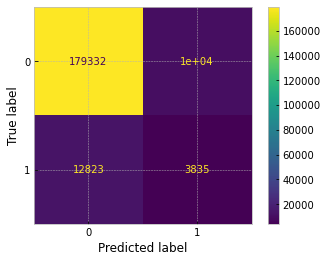

In [168]:
gbm_smt_pipe.print_summary()

##### Feature Engineering 

Our models are taking too long to run and we have more than 210 columns, we do some feature engineering and run the models to see if the model results are better.

In [67]:
# column represent the credit/income percentage
X_train['Credit/Income'] = X_train['AMT_CREDIT']/X_train['AMT_INCOME_TOTAL']
X_test['Credit/Income'] = X_test['AMT_CREDIT']/X_test['AMT_INCOME_TOTAL']

In [68]:
# column represent the annuity/income percentage
X_train['Annuity/Income'] = X_train['AMT_ANNUITY']/X_train['AMT_INCOME_TOTAL']
X_test['Annuity/Income'] = X_test['AMT_ANNUITY']/X_test['AMT_INCOME_TOTAL']

In [69]:
# column represent days employed percentage
X_train['Employed/Birth'] = X_train['DAYS_EMPLOYED']/X_train['DAYS_BIRTH']
X_test['Employed/Birth'] = X_test['DAYS_EMPLOYED']/X_test['DAYS_BIRTH']

In [70]:
# flag represents if he's greater than 32 or not
X_train['Flag_Greater_32'] = (X_train['DAYS_BIRTH']/-365.25).apply(lambda x: 1 if x > 32 else 0)
X_test['Flag_Greater_32'] = (X_test['DAYS_BIRTH']/-365.25).apply(lambda x: 1 if x > 32 else 0)

In [71]:
# flag represents if his employmeny years is greater than 5 or not
X_train['Flag_Employment_Greater_5'] = (X_train['DAYS_EMPLOYED']/-365.25).apply(lambda x: 1 if x > 5 else 0)
X_test['Flag_Employment_Greater_5'] = (X_test['DAYS_EMPLOYED']/-365.25).apply(lambda x: 1 if x > 5 else 0)

In [72]:
# flag represents if his income is greater than the loan or not
X_train['Flag_Income_Greater_Credit'] = X_train['AMT_INCOME_TOTAL'] > X_train['AMT_CREDIT'] 
X_test['Flag_Income_Greater_Credit'] = X_test['AMT_INCOME_TOTAL'] > X_test['AMT_CREDIT'] 

In [73]:
# create polynomial features of the top 2 pos & neg features with target
cols = ['DAYS_LAST_PHONE_CHANGE', 'REGION_RATING_CLIENT','EXT_SOURCE_3', 'EXT_SOURCE_2']

for col in cols:
    for i in [2,3]:
        X_train[f'{col}_power_{i}'] = X_train[col] ** i
        X_test[f'{col}_power_{i}'] = X_test[col] ** i

In [74]:
X_train.head() #reduced the columns to 90 columns from 210 columns

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,Flag_Employment_Greater_5,Flag_Income_Greater_Credit,DAYS_LAST_PHONE_CHANGE_power_2,DAYS_LAST_PHONE_CHANGE_power_3,REGION_RATING_CLIENT_power_2,REGION_RATING_CLIENT_power_3,EXT_SOURCE_3_power_2,EXT_SOURCE_3_power_3,EXT_SOURCE_2_power_2,EXT_SOURCE_2_power_3
137880,259903,Cash loans,F,N,Y,0,180000.0,659610.0,21406.5,472500.0,...,0,False,461041.0,-3.130468e+08,4,8,0.209672,0.096009,0.102172,0.032659
284412,429375,Revolving loans,F,N,Y,0,270000.0,675000.0,33750.0,675000.0,...,1,False,1225449.0,-1.356572e+09,4,8,0.311930,0.174215,0.550942,0.408939
32185,137318,Revolving loans,F,N,Y,0,90000.0,135000.0,6750.0,135000.0,...,0,False,5764801.0,-1.384129e+10,4,8,0.056604,0.013467,0.449633,0.301500
125667,245726,Cash loans,F,N,N,0,112500.0,284400.0,15138.0,225000.0,...,0,False,1.0,-1.000000e+00,1,1,NaN,NaN,0.531549,0.387539
290509,436566,Cash loans,F,N,Y,0,157500.0,343800.0,10921.5,225000.0,...,0,False,2116.0,-9.733600e+04,4,8,0.204787,0.092673,0.447638,0.299495


Modeling again 

Dummy Model

In [195]:
# create pipeline
dum = DummyClassifier(strategy='most_frequent', random_state=42)
steps = [('ct', ct), ('oversampler', oversampler), ('undersampler', undersampler), ('model', dum)]
dum_pipeline = ImPipeline(steps=steps)

# train 
dum_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cont',
                                                  Pipeline(steps=[('get_cont',
                                                                   FunctionTransformer(func=<function grab_continuous at 0x7f7caa53c3a0>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 5, 6, 7, 8, 9, 15, 16, 17,
                                                   18, 19, 27, 28, 29, 31, 32,
                                                   33, 34, 35, 36, 37, 39, 40,
                                                   41, 42, 43, 44, 45, 66, 67, ...]),
                                        

In [196]:
dum_smt_fr_pipe = ModelWithCV(dum_pipeline, 'dum_pipeline', X_train, y_train)

In [260]:
pickle_model(dum_smt_fr_pipe, 'dum_smt_fr_pipe')

Saving model as dum_smt_fr_pipe...
dum_smt_fr_pipe succesfully saved.


In [ ]:
# dum_smt_fr_pipe=pickle.load(open('pickled_models/dum_smt_fr_pipe.sav'))

<AxesSubplot:title={'center':'CV Results for `dum_pipeline` Model'}>

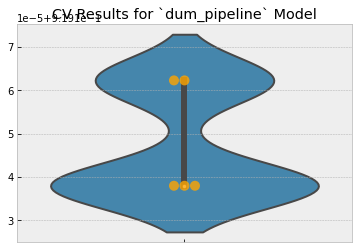

In [197]:
fig, ax = plt.subplots()
dum_smt_fr_pipe.plot_cv(ax)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.0 CV Results for `dum_pipeline` model:
            0.91915 ± 0.00001 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f7aaf0b3dc0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f7aa7b2c4c0>


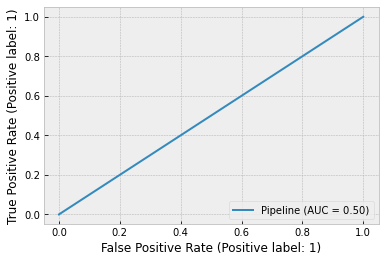

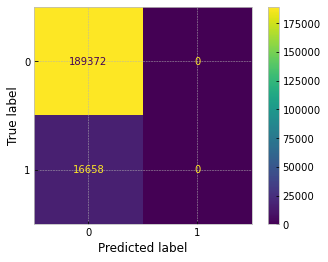

In [198]:
dum_smt_fr_pipe.print_summary()

Random Forest

In [122]:
# create pipeline
rfc2 = RandomForestClassifier(n_estimators=75, max_depth=25, random_state=42, n_jobs=-2)
steps = [('ct', ct), ('oversampler', oversampler), ('undersampler', undersampler), ('model', rfc2)]
rf_pipeline4 = ImPipeline(steps=steps)

# train 
rf_pipeline4.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cont',
                                                  Pipeline(steps=[('get_cont',
                                                                   FunctionTransformer(func=<function grab_continuous at 0x7fb0f56511f0>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 5, 6, 7, 8, 9, 15, 16, 17,
                                                   18, 19, 27, 28, 29, 31, 32,
                                                   33, 34, 35, 36, 37, 39, 40,
                                                   41, 42, 43, 44, 45, 66, 67, ...]),
                                        

In [124]:
rf_smt_fr_pipe = ModelWithCV(rf_pipeline4, 'rf_pipeline4', X_train, y_train)

In [125]:
pickle_model(rf_smt_fr_pipe, 'rf_smt_fr_pipe')

Saving model as rf_smt_fr_pipe...
rf_smt_fr_pipe succesfully saved.


In [126]:
# rf_smt_fr_pipe=pickle.load(open('pickled_models/rf_smt_fr_pipe.sav'))

<AxesSubplot:title={'center':'CV Results for `rf_pipeline4` Model'}>

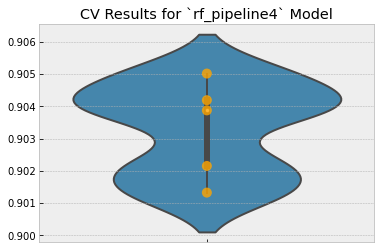

In [127]:
fig, ax = plt.subplots()
rf_smt_fr_pipe.plot_cv(ax)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.8830810034257928 CV Results for `rf_pipeline4` model:
            0.90353 ± 0.00050 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f7aabbb6790> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f7ab085d430>


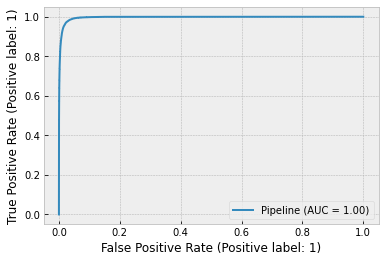

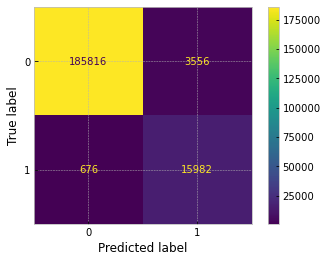

In [202]:
rf_smt_fr_pipe.print_summary()

Ada Boosting

In [191]:
# create pipeline
adaboost = AdaBoostClassifier(n_estimators=200, random_state=42, )
steps = [('ct', ct), ('oversampler', oversampler), ('undersampler', undersampler), ('model', adaboost)]
ada_pipeline4 = ImPipeline(steps=steps)

# train 
ada_pipeline4.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cont',
                                                  Pipeline(steps=[('get_cont',
                                                                   FunctionTransformer(func=<function grab_continuous at 0x7f7caa53c3a0>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 5, 6, 7, 8, 9, 15, 16, 17,
                                                   18, 19, 27, 28, 29, 31, 32,
                                                   33, 34, 35, 36, 37, 39, 40,
                                                   41, 42, 43, 44, 45, 66, 67, ...]),
                                        

In [192]:
ada_smt_fr_pipe = ModelWithCV(ada_pipeline4, 'ada_pipeline4', X_train, y_train)

In [262]:
pickle_model(ada_smt_fr_pipe, 'ada_smt_fr_pipe')

Saving model as ada_smt_fr_pipe...
ada_smt_fr_pipe succesfully saved.


In [ ]:
# ada_smt_fr_pipe = pickle.load(open('pickled_models/ada_smt_fr_pipe.sav'))

<AxesSubplot:title={'center':'CV Results for `ada_pipeline4` Model'}>

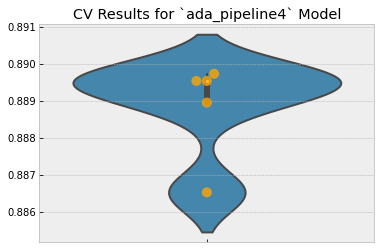

In [193]:
fig, ax = plt.subplots()
ada_smt_fr_pipe.plot_cv(ax)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.25589697394321553 CV Results for `ada_pipeline4` model:
            0.88885 ± 0.00119 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f7aacf95a00> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7f7aac3dba90>


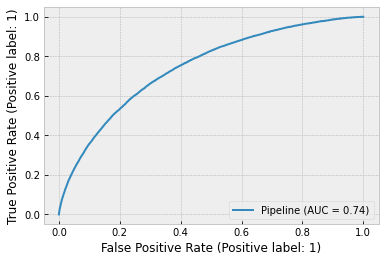

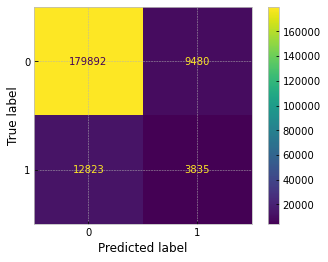

In [194]:
ada_smt_fr_pipe.print_summary()

The models after SMOTE and feature engineering, the models have a higher F1 score and AUC metrics than the dummy model. 

We can run a grid search on the random forest algorithm and try to improve the model score further. 

In [75]:
# create pipeline
rf_pipeline5 = ImPipeline(steps=[
    ('ct', ct), 
    ('oversampler', oversampler), 
    ('undersampler', undersampler), 
    ('model', RandomForestClassifier(n_jobs=-2))
]).fit(X_train, y_train)

In [76]:
# GridSearch

params2 = {}

params2['model__n_estimators'] = [10,100,1000]
params2['model__criterion'] = ['gini', 'entropy']
params2['model__min_samples_split'] = [10,100,1000]
params2['model__max_depth'] = [10,25, 50]

In [77]:
params2

{'model__n_estimators': [10, 100, 1000],
 'model__criterion': ['gini', 'entropy'],
 'model__min_samples_split': [10, 100, 1000],
 'model__max_depth': [10, 25, 50]}

In [78]:
gs2 = GridSearchCV(
    estimator = rf_pipeline5, 
    param_grid=params2, 
    cv = 5, n_jobs=-2,
    scoring='f1_micro'
)

In [79]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_cont',
                                                                         Pipeline(steps=[('get_cont',
                                                                                          FunctionTransformer(func=<function grab_continuous at 0x7fba11a53ee0>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         [0, 5,
                                                                          6, 7,
  

In [80]:
pickle_model(gs2, 'gs2')

Saving model as gs2...
gs2 succesfully saved.


In [81]:
# gs2=pickle.load(open('pickled_models/gs2.sav'))

In [82]:
gs2.cv_results_

{'mean_fit_time': array([ 31.42053218,  48.86146021, 315.38047085, 100.439607  ,
         75.42432342, 306.00855832,  85.47911544,  69.06520381,
        274.3424509 ,  88.24708171,  70.19754505, 409.81504073,
         89.16828632,  99.06222887, 371.15992303,  90.11829414,
         78.57949071, 292.1294342 ,  85.17664404,  77.19289069,
        409.81259766,  89.67457223,  96.32133512, 371.53015461,
         87.94774694,  78.57497864, 296.45789642,  88.93157325,
         68.39063044, 306.56547852,  85.66660271,  74.39805937,
        305.40431118,  84.12000484,  70.76710854, 281.46862936,
         84.86511922,  79.67710314, 447.67981377,  88.37101827,
        100.88695731, 404.67534676,  92.14461384,  80.31333928,
        316.81947203,  88.94662843,  86.44722548, 442.49140549,
         83.84907007, 107.42695704, 402.50857468,  83.33622437,
         91.62393236, 294.24630346]),
 'std_fit_time': array([ 2.01884398,  6.93088805,  3.73013551, 29.47418818,  2.62626252,
         7.37970861, 25.

In [83]:
gs2.cv_results_['mean_test_score']

array([0.88737077, 0.89618017, 0.89478717, 0.8783915 , 0.89496675,
       0.89558317, 0.88183274, 0.89268068, 0.89345726, 0.8816483 ,
       0.90596515, 0.90789691, 0.89440373, 0.90409649, 0.90564966,
       0.8891375 , 0.89746639, 0.89777217, 0.88260448, 0.90672718,
       0.90876086, 0.89436004, 0.90486822, 0.90568849, 0.89106441,
       0.896617  , 0.89789836, 0.88232782, 0.89462214, 0.89607339,
       0.88941416, 0.8950347 , 0.89663156, 0.88190555, 0.89248653,
       0.89411736, 0.88474494, 0.90597971, 0.90860069, 0.89485026,
       0.90536815, 0.9060331 , 0.88560404, 0.8969519 , 0.89867495,
       0.88268213, 0.90760569, 0.90956657, 0.89520458, 0.90536815,
       0.90636315, 0.88830267, 0.89861185, 0.89805368])

In [84]:
gs2.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 50,
 'model__min_samples_split': 10,
 'model__n_estimators': 1000}

### Final model

We select Random Forest with the best parameters from the grid search to be our final model. Due to limitations in the computational power at the moment, we stop the process of iterating the models and parameters. In the future, to improve the model further, we could just model stacking and deep dive further into the model parameter tuning.

In [128]:
# final pipeline
final_rfc = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=50, min_samples_split=10, random_state=42, n_jobs=-2)
steps = [('ct', ct), ('oversampler', oversampler), ('undersampler', undersampler), ('model', final_rfc)]
final_rfc_pipeline = ImPipeline(steps=steps)

# train 
final_rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_cont',
                                                  Pipeline(steps=[('get_cont',
                                                                   FunctionTransformer(func=<function grab_continuous at 0x7fb0f56511f0>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  [0, 5, 6, 7, 8, 9, 15, 16, 17,
                                                   18, 19, 27, 28, 29, 31, 32,
                                                   33, 34, 35, 36, 37, 39, 40,
                                                   41, 42, 43, 44, 45, 66, 67, ...]),
                                        

In [129]:
final_rfc_cv_pipeline = ModelWithCV(final_rfc_pipeline, 'final_rfc_pipeline', X_train, y_train)

In [130]:
pickle_model(final_rfc_cv_pipeline, 'final_rfc_cv_pipeline.sav')

Saving model as final_rfc_cv_pipeline.sav...
final_rfc_cv_pipeline.sav succesfully saved.


In [131]:
# final_rfc_cv_pipeline=pickle.load(open('pickled_models/final_rfc_cv_pipeline.sav'))

<AxesSubplot:title={'center':'CV Results for `final_rfc_pipeline` Model'}>

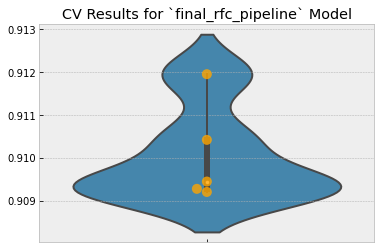

In [132]:
fig, ax = plt.subplots()
final_rfc_cv_pipeline.plot_cv(ax)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.8545616641901932 CV Results for `final_rfc_pipeline` model:
            0.91007 ± 0.00104 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7faaf4f39fa0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7fad054171c0>


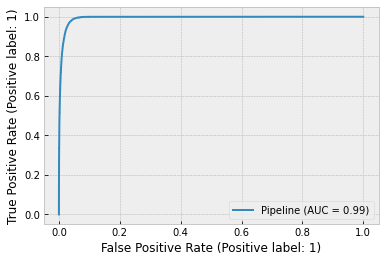

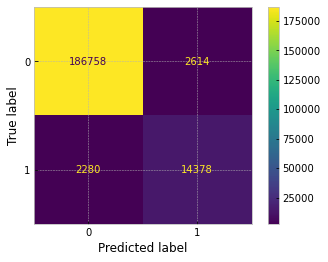

In [133]:
final_rfc_cv_pipeline.print_summary()

Testing the final model on the test dataset

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


 
  f1_score is 0.1636197440585009 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7faaf71bb730> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7faab97a8580>


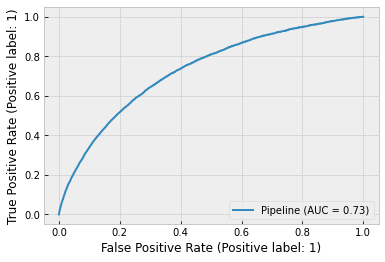

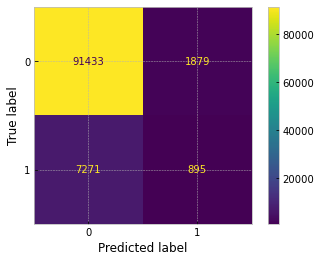

In [134]:
roc = plot_roc_curve(final_rfc_pipeline, X_test , y_test);
cm = plot_confusion_matrix(final_rfc_pipeline, X_test, y_test);
preds = final_rfc_pipeline.predict(X_test)
f1_ = f1_score(y_test, preds)
print(f' \n  f1_score is {f1_}',cm, roc)

## Visualizations

In [76]:
X_train.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE'

#### 1. Gender

In [77]:
train_df['CODE_GENDER'].value_counts().values

array([202445, 105059,      4])

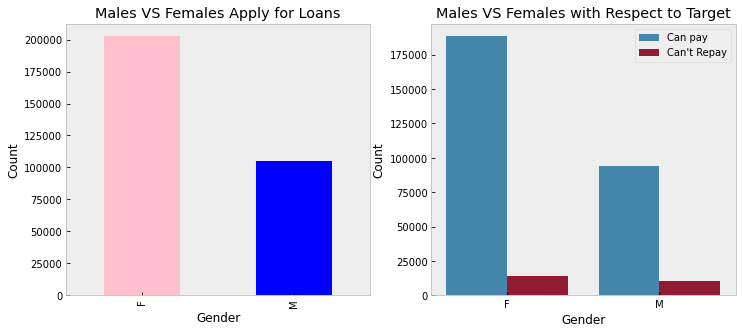

In [81]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 20))
# ax1.bar(train_df['CODE_GENDER'].value_counts().index, train_df['CODE_GENDER'].value_counts().values)
# ax1.set_xlabel("Gender")
# ax1.set_ylabel("Count")

# ind=np.arrange(len(train_df['CODE_GENDER'].value_counts().index))
# ax2.bar(ind, )
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
train_df[train_df['CODE_GENDER']!='XNA']['CODE_GENDER'].value_counts().plot(kind='bar', title='Males VS Females Apply for Loans', color=['pink','blue']);
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(np.arange(2), ['F', 'M'])
plt.grid(b=False)

plt.subplot(1, 2, 2)
sns.countplot(data=train_df[train_df['CODE_GENDER']!='XNA'], x='CODE_GENDER', hue='TARGET', order=['F', 'M']);
plt.title('Males VS Females with Respect to Target')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(b=False)
plt.legend(['Can pay','Can\'t Repay']);
plt.savefig('Images/Gender.png', bbox_inches='tight', dpi=1000)

- Females apply for more loans than Males 
- However, target is not affected by the gender

### 2. Loan Type

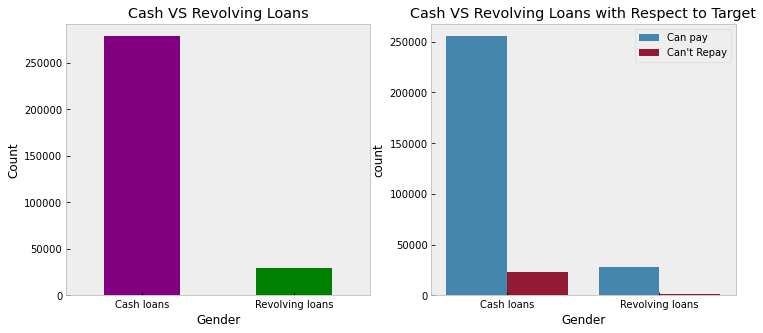

In [85]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
train_df['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar', title='Cash VS Revolving Loans', color=['purple','green']);
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(b=False)

plt.subplot(1, 2, 2)
sns.countplot(data=train_df, x='NAME_CONTRACT_TYPE', hue='TARGET')
plt.title('Cash VS Revolving Loans with Respect to Target')
plt.grid(b=False)
plt.xlabel('Gender')
plt.legend(['Can pay','Can\'t Repay']);
plt.savefig('Images/LoanType.png', bbox_inches='tight', dpi=1000)

- Cash loans are more common than revolving loans
- cash loans have higher default than revolving loans. 

### 3. Age of the applicant

<ipython-input-90-90d085c0418e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proper_day_birth_df['DAYS_BIRTH'] = proper_day_birth_df['DAYS_BIRTH']/-365.25
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either

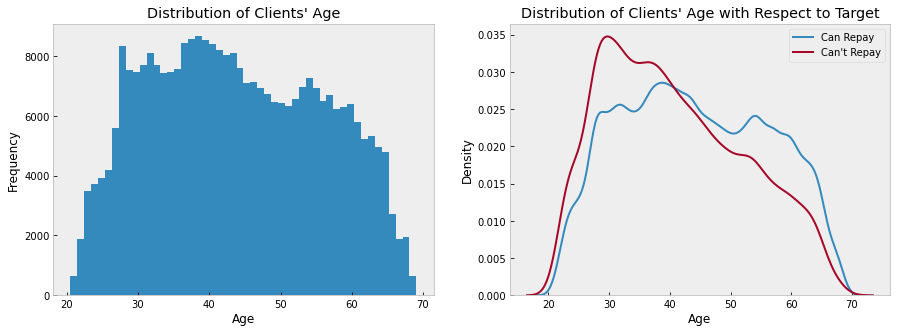

In [90]:
# Is there relation between the age and the ability to repay?

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
(train_df['DAYS_BIRTH']/-365.25).plot(kind='hist', bins=50, title='Distribution of Clients\' Age');
plt.xlabel('Age')
plt.grid(b=False)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
proper_day_birth_df = train_df[['DAYS_BIRTH', 'TARGET']]
proper_day_birth_df['DAYS_BIRTH'] = proper_day_birth_df['DAYS_BIRTH']/-365.25
sns.distplot(proper_day_birth_df[proper_day_birth_df['TARGET']==0]['DAYS_BIRTH'], hist=False, label='Can Repay');
sns.distplot(proper_day_birth_df[proper_day_birth_df['TARGET']==1]['DAYS_BIRTH'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Clients\' Age with Respect to Target')
plt.xlabel('Age')
plt.grid(b=False)
plt.legend();
plt.savefig('Images/Age.png', bbox_inches='tight', dpi=1000)

- Applicants of the age of 30 have difficulty paying off the loans 
- Applicants of the age of 40 can repay well

### 4. Client's Income

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


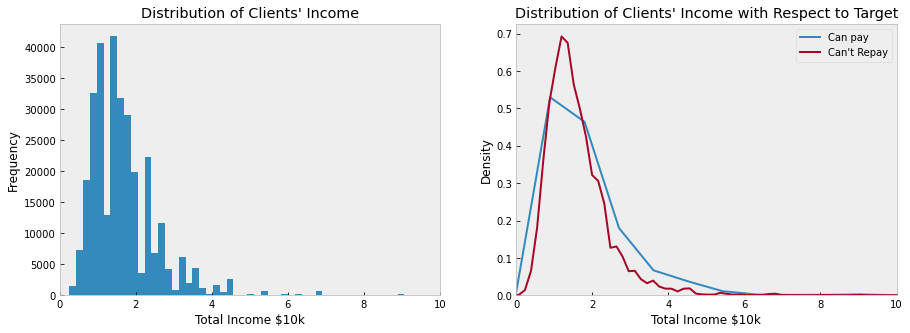

In [86]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
proper_income_df = train_df[train_df['AMT_INCOME_TOTAL']!=117000000.0]
proper_income_df['AMT_INCOME_TOTAL'] = proper_income_df['AMT_INCOME_TOTAL']/100000
proper_income_df['AMT_INCOME_TOTAL'].plot(kind='hist', bins=1000, title='Distribution of Clients\' Income');
plt.xlabel('Total Income $10k')
plt.xlim([0,10])
plt.grid(b=False)

plt.subplot(1, 2, 2)
sns.distplot(proper_income_df[proper_income_df['TARGET']==0]['AMT_INCOME_TOTAL'], hist=False, bins=1000, label='Can Repay');
sns.distplot(proper_income_df[proper_income_df['TARGET']==1]['AMT_INCOME_TOTAL'], hist=False, bins=1000, label='Can\'t Repay');
plt.title('Distribution of Clients\' Income with Respect to Target')
plt.xlabel('Total Income $10k')
plt.xlim([0,10])
plt.grid(b=False)
plt.legend(['Can pay','Can\'t Repay']);
plt.savefig('Images/Income.png', bbox_inches='tight', dpi=1000)

- People with lower incomes, apply for loans more
- People with income between 115,000 and 228,000 have difficulty repaying the loans

In [243]:
amt['AMT_INCOME_TOTAL'].describe()

count    8.000000e+00
mean     2.384079e+06
std      6.310347e+06
min      2.565000e+04
25%      1.115780e+05
50%      1.577842e+05
75%      2.287520e+05
max      1.800009e+07
Name: AMT_INCOME_TOTAL, dtype: float64

### 5. Type of clients

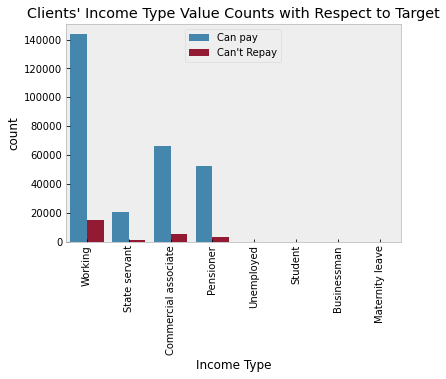

In [87]:
ax = sns.countplot(data=train_df, x='NAME_INCOME_TYPE', hue='TARGET');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90);
plt.title('Clients\' Income Type Value Counts with Respect to Target')
plt.xlabel('Income Type')
plt.grid(b=False)
plt.legend(['Can pay','Can\'t Repay']);

print('\n'*2)
train_df.groupby('NAME_INCOME_TYPE')['TARGET'].value_counts()

plt.savefig('Images/Employment.png', bbox_inches='tight', dpi=1000)

- Working clients are more willing to apply for loans more than others.
- Altought a few businessmen and students apply for loans, but they always repay.

### 6. Employment of the applicant

<ipython-input-103-6c10ec176fbb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proper_days_empolyed_df['YEARS_EMPLOYED'] = proper_days_empolyed_df['DAYS_EMPLOYED']/-365.25
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use 

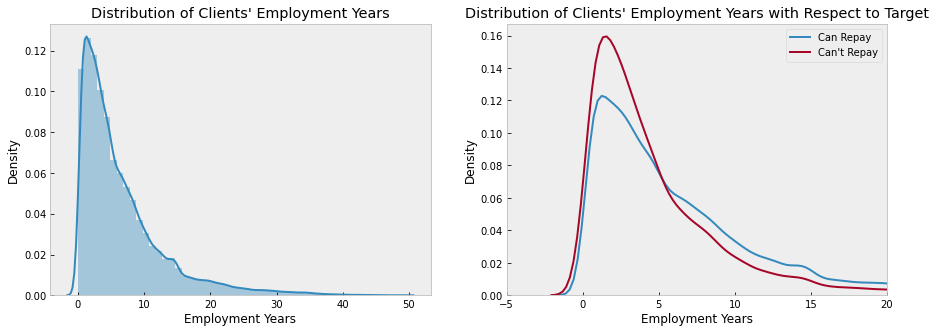

In [103]:
proper_days_empolyed_df = train_df[train_df['DAYS_EMPLOYED']!=365243]
proper_days_empolyed_df['YEARS_EMPLOYED'] = proper_days_empolyed_df['DAYS_EMPLOYED']/-365.25

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(proper_days_empolyed_df['YEARS_EMPLOYED'])
plt.title('Distribution of Clients\' Employment Years')
plt.xlabel('Employment Years')
plt.grid(b=False)

plt.subplot(1, 2, 2)
sns.distplot(proper_days_empolyed_df[proper_days_empolyed_df['TARGET']==0]['YEARS_EMPLOYED'], hist=False, label='Can Repay');
sns.distplot(proper_days_empolyed_df[proper_days_empolyed_df['TARGET']==1]['YEARS_EMPLOYED'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Clients\' Employment Years with Respect to Target');
plt.xlim([-5,20])
plt.xlabel('Employment Years')
plt.legend()
plt.grid(b=False);

plt.savefig('Images/EmploymentYrs.png', bbox_inches='tight', dpi=1000)

Clients with employment years less than 5 years tend to apply for loans more than others, and they are less likely to repay, especially less than 2 years, vice versa.

In [69]:
train_df.head(1)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
